<a href="https://colab.research.google.com/github/Aaditya-Prasad/APML/blob/main/Transformers/AnnotatedViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torch.utils.data import RandomSampler, DataLoader, Subset
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms
from torch.nn.parallel import DistributedDataParallel as DDP
import torchvision.datasets as datasets
import cv2 as cv
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
# Constants
PATCH_SIZE = 4
NUM_PATCHES = 28//PATCH_SIZE #this is the number of patches on a side length, total patches is this squared
D_MODEL = 16
FINAL_HIDDEN_DIM = 16 #this is the dimension of the hidden layer 
CLASSES = 10 #10 different numbers to classify between

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

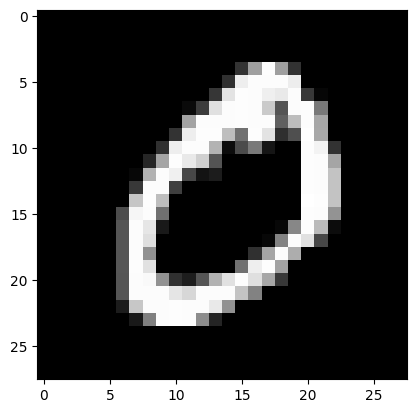

In [4]:
plt.imshow(mnist_trainset[1][0], cmap = 'gray')

In [5]:
def patchify(x):
    x = torch.tensor(np.array(x)).to(dtype=torch.float32) #MNIST is in uint8, so we need to convert it to float32
    tokens = []
    for i in range(NUM_PATCHES):
        for j in range(NUM_PATCHES):
            tokens.append(x[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE].reshape(-1))
    return torch.stack(tokens)


In [78]:
class Embeddings(nn.Module):
    def __init__(self, D_MODEL):
        super().__init__()
        self.D_MODEL = D_MODEL
        self.lin = nn.Linear(PATCH_SIZE**2, D_MODEL)
        self.pos = nn.Parameter(torch.randn(NUM_PATCHES**2+1, D_MODEL))
        self.y = nn.Parameter(torch.randn(1, D_MODEL))
    

    def forward(self, x):
        #linear projection to D_MODEL
        x = self.lin(x)
        #prepend the class embedding
        x = torch.cat((self.y.unsqueeze(0), x), dim=0)
        #add positional embeddings
        x = x + self.pos
        return x


In [40]:
class LayerNorm(nn.Module):
    #we will put tokens in as features so that layernorm knows the size of the input it has to norm across
    def __init__(self, features, eps = 1e-6):
        super().__init__()
        self.a = nn.Parameter(torch.ones(features)) #learned weights
        self.b = nn.Parameter(torch.zeros(features)) #learned bias
        self.eps = eps #this is so that we don't divide by zero in forward
    
    def forward(self, tokens):
        mean = tokens.mean(-1, keepdim = True) #this takes the mean across every row (which is the mean across every patch)
        std = tokens.std(-1, keepdim = True) #this takes the std across every patch
        return self.a * (tokens-mean)/(std + self.eps) + self.b #this first normalizes every patch and then does a learned linear transformation on it 

In [ ]:
class PreTrainingMLP(nn.Module):
    def __init__(self, D_MODEL, FINAL_HIDDEN_DIM):
        super().__init__()
        self.lin1 = nn.Linear(D_MODEL, FINAL_HIDDEN_DIM)
        self.lin2 = nn.Linear(FINAL_HIDDEN_DIM, D_MODEL)
        self.act = nn.GELU()
        self.layers = nn.Sequential(self.lin1, self.act, self.lin2)
    
    def forward(self, tokens):
        return self.layers(tokens)

In [ ]:
#The first row in every batch of the transformer ouput is the changed class token. 
#We run this class token through a final module to compute classifications
#The final module is an MLP with one hidden layer at pretraining time and it's a linear layer at finetuning time
class Classifier(nn.Module):
    def __init__(self, D_MODEL, CLASSES, FINAL_HIDDEN_DIM, pretrainingMLP, transformer, embeddings):
        super().__init__()
        self.pretraining = pretrainingMLP
        self.finetuning = nn.Linear(D_MODEL, CLASSES)
        self.tr = transformer
        self.em = embeddings
        self.pretraining = True

    def switch_to_finetuning(self):
        self.pretraining = False

    def switch_to_pretraining(self):
        self.pretraining = True
    
    def forward(self, tokens):
        


TypeError: GELU.__init__() got an unexpected keyword argument 'inplace'

In [15]:
tokens0 = patchify(mnist_trainset[1][0])
tokens1 = patchify(mnist_testset[2][0])
tokens0.shape
lin = nn.Linear(16, 10)
lin(tokens0).shape


torch.Size([49, 10])

In [32]:
em = Embeddings(D_MODEL)
em0 = em(tokens0)
em1 = em(tokens1)
batch = torch.stack([em0, em1])
batch.shape
#One forward pass!


torch.Size([2, 50, 16])

In [34]:
em0.shape
em1.shape

torch.Size([50, 16])

In [49]:
ln = LayerNorm(em0.shape)
normed_batch = ln(batch)
#normed_batch.mean(-1, keepdim=True) ~ torch.zeros(normed_batch)

In [79]:
em(torch.stack([tokens0, tokens1]))

RuntimeError: Tensors must have same number of dimensions: got 2 and 3